Розробити власну архітектуру GAN для датасету fashion mnist  для побудови реалістичного зображення певного типу одягу, наприклад, штанів, футболки, сукні.
Необхідно завантажити датасет, вивести типи одягу, що містить датасет.
Підготувати дані, підібрати кількість шарів, функції активації і тд.
Побудувати графік функції втрат, вивести значення функції втрат. Вивести результат.



Завантаження датасету та створення класів

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

(x_train, _), (_, _) = fashion_mnist.load_data()


class_names = ['Футболка', 'Штани', 'Світшот', 'Сукня', 'Пальто',
               'Сандалі', 'Сорочка', 'Кросівки', 'Сумка', 'Чоботи']

for i in range(10):
    print(f"Клас {i}: {class_names[i]}")

x_train = x_train.astype('float32') / 255.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))


print(f"Розмір x_train: {x_train.shape}")


Клас 0: Футболка
Клас 1: Штани
Клас 2: Світшот
Клас 3: Сукня
Клас 4: Пальто
Клас 5: Сандалі
Клас 6: Сорочка
Клас 7: Кросівки
Клас 8: Сумка
Клас 9: Чоботи
Розмір x_train: (60000, 28, 28, 1)


Вибір речі(футболка)

In [ ]:
x_train_selected = x_train[y_train == 0]
print(f"Розмір x_train_selected: {x_train_selected.shape}")


Розмір x_train_selected: (6000, 28, 28, 1)


Функція побудови генератора та дискримінатора




In [ ]:
latent_dim = 100

def build_generator():
    model = Sequential()
    model.add(Dense(7*7*256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)

=validity = discriminator(img)

gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))


навчання GAN

4/4 [==============================] - 1s 187ms/step
Епоха 1/10, Діс: 0.7114479839801788, Ген: 0.6665181517601013, Час: 240.0348265171051 сек
4/4 [==============================] - 1s 192ms/step
Епоха 2/10, Діс: 0.727243572473526, Ген: 0.6450965404510498, Час: 235.899507522583 сек
4/4 [==============================] - 1s 185ms/step
Епоха 3/10, Діс: 0.7076422572135925, Ген: 0.7018873691558838, Час: 237.98888397216797 сек
4/4 [==============================] - 1s 181ms/step
Епоха 4/10, Діс: 0.6957403421401978, Ген: 0.6964459419250488, Час: 236.76675724983215 сек
4/4 [==============================] - 1s 187ms/step
Епоха 5/10, Діс: 0.6911195516586304, Ген: 0.7046570777893066, Час: 236.93075156211853 сек
4/4 [==============================] - 1s 183ms/step
Епоха 6/10, Діс: 0.699081152677536, Ген: 0.6946037411689758, Час: 238.41360521316528 сек
4/4 [==============================] - 1s 186ms/step
Епоха 7/10, Діс: 0.6943864226341248, Ген: 0.7061562538146973, Час: 236.00904512405396 сек
4/4 

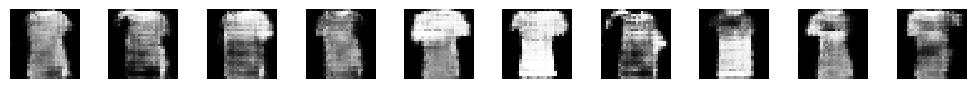

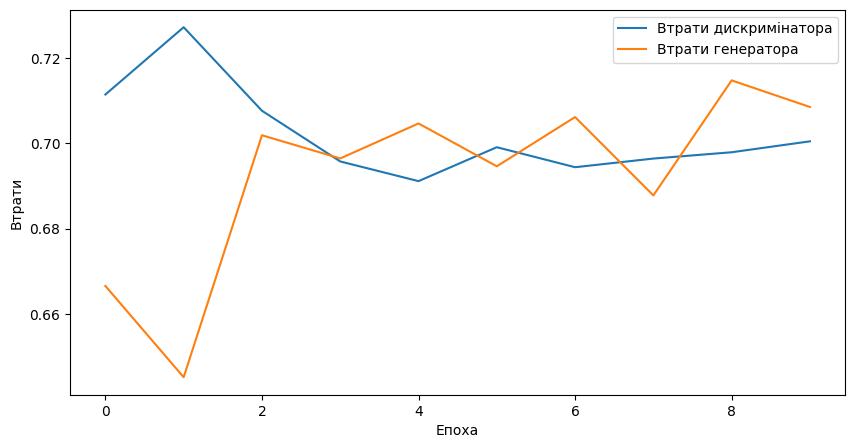

In [ ]:
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses["d"], label='Втрати дискримінатора')
    plt.plot(losses["g"], label='Втрати генератора')
    plt.xlabel('Епоха')
    plt.ylabel('Втрати')
    plt.legend()
    plt.show()

def train_gan(epochs, batch_size=128, save_interval=50):
    losses = {"d": [], "g": []}

    batch_count = x_train_selected.shape[0] // batch_size

    for epoch in range(epochs):
        start_time = time.time()

        for batch_index in range(batch_count):
            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            imgs = x_train_selected[np.random.randint(0, x_train_selected.shape[0], batch_size)]

            gen_imgs = generator.predict(noise)

            valid = np.ones((batch_size, 1))
            fake = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            g_loss = gan.train_on_batch(noise, valid)

        losses["d"].append(d_loss)
        losses["g"].append(g_loss)

        print(f"Епоха {epoch + 1}/{epochs}, Діс: {d_loss}, Ген: {g_loss}, Час: {time.time() - start_time} сек")

        if (epoch + 1) % save_interval == 0:
            plot_generated_images(epoch + 1, generator)

    plot_losses(losses)
def plot_generated_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 0], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.show()

train_gan(epochs=10, batch_size=128, save_interval=10)


Намалювати крижинку Коха з можливістю вибору рівня рекурсії.

Намалювати килим Серпинського.

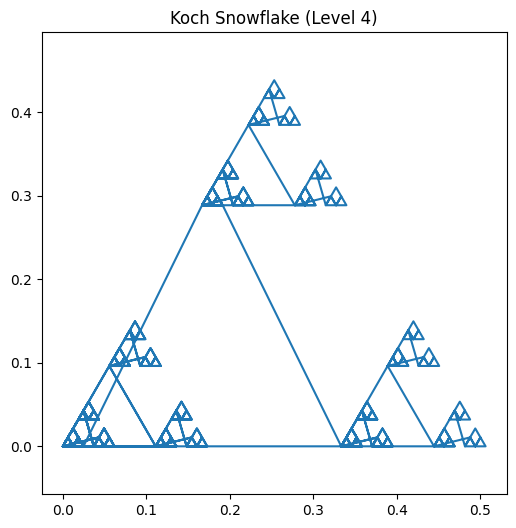

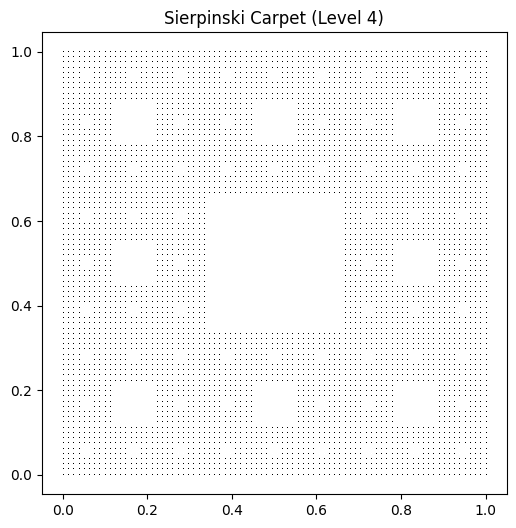

In [ ]:
def koch_snowflake(x, y, length, level):
    if level == 0:
        return [(x, y), (x + length / 2, y + np.sqrt(3) * length / 2),
                (x + length, y), (x, y)]
    else:
        new_length = length / 3
        p1 = koch_snowflake(x, y, new_length, level - 1)
        p2 = koch_snowflake(x + new_length, y, new_length, level - 1)
        p3 = koch_snowflake(x + new_length / 2, y + np.sqrt(3) * new_length / 2,
                            new_length, level - 1)
        return p1[:-1] + p3[:-1] + p2[:-1] + p1[:-1]

def plot_koch_snowflake(level):
    length = 1.0
    vertices = koch_snowflake(0, 0, length, level)
    x, y = zip(*vertices)
    plt.figure(figsize=(6, 6))
    plt.plot(x, y)
    plt.axis('equal')
    plt.title(f'Крижинка Коха (Level {level})')
    plt.show()

def sierpinski_carpet(x, y, length, level):
    if level == 0:
        return [(x, y), (x + length, y), (x + length, y + length),
                (x, y + length), (x, y)]
    else:
        new_length = length / 3
        points = []
        for i in range(3):
            for j in range(3):
                if i != 1 or j != 1:
                    points += sierpinski_carpet(x + i * new_length, y + j * new_length,
                                                new_length, level - 1)
        return points

def plot_sierpinski_carpet(level):
    length = 1.0
    vertices = sierpinski_carpet(0, 0, length, level)
    x, y = zip(*vertices)
    plt.figure(figsize=(6, 6))
    plt.plot(x, y, 'k,')
    plt.axis('equal')
    plt.title(f'Килим Серпанського (Level {level})')
    plt.show()

plot_koch_snowflake(4)
plot_sierpinski_carpet(4)